In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib.summary2 as summary2

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas(\
                                    ["patent", "appyear", "gyear", "naics_name", "primclass", "inv_msa"]).drop_duplicates("patent")

def get_year_group_10(x):
    if x in range(1975,1985):
        yg = "1975-85"
    elif x in range(1985,1995):
        yg = "1985-95"
    elif x in range(1995, 2005):
        yg = "1995-05"
    elif x in range(2005,2015):
        yg = "2005-15"
    else:
        yg = np.nan
    return yg

pdf["year_group"] = pdf["gyear"].apply(get_year_group_10)

### Concentration of innovation in top 5 cities

In [9]:
dec75 = pdf.loc[pdf["year_group"] == "1975-85"].groupby("inv_msa").size().sort_values(ascending=False)
dec05 = pdf.loc[pdf["year_group"] == "2005-15"].groupby("inv_msa").size().sort_values(ascending=False)
print(sum(dec75[:5])/sum(dec75), sum(dec75[:10])/sum(dec75), sum(dec05[:5])/sum(dec05), sum(dec05[:10])/sum(dec05))

0.29085720638920803 0.39932550124152244 0.31093933724831274 0.4552917795520603


In [8]:
dec75

inv_msa
New York-Northern New Jersey-Long Island, NY-NJ-PA    26566
Chicago-Joliet-Naperville, IL-IN-WI                   16247
Los Angeles-Long Beach-Santa Ana, CA                  16160
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD           10307
Boston-Cambridge-Quincy, MA-NH                         9202
Detroit-Warren-Livonia, MI                             6805
San Francisco-Oakland-Fremont, CA                      6158
San Jose-Sunnyvale-Santa Clara, CA                     5889
Houston-Sugar Land-Baytown, TX                         5591
Pittsburgh, PA                                         4825
Minneapolis-St. Paul-Bloomington, MN-WI                4547
Cleveland-Elyria-Mentor, OH                            4241
Dallas-Fort Worth-Arlington, TX                        3946
Washington-Arlington-Alexandria, DC-VA-MD-WV           3835
Rochester, NY                                          3663
Bridgeport-Stamford-Norwalk, CT                        3529
San Diego-Carlsbad-San Marcos, C

## 1. Similarity in location distribution over time

In [77]:
yr_min = 1976
yr_max = 2015
k = "inv_msa"
yr_v = "gyear"
pdf = pdf.loc[pdf[yr_v].isin(range(yr_min,yr_max+1))]
ploc = pdf[[k, yr_v, "patent"]].groupby([k, yr_v]).count().reset_index()
# Only use those places with greater than 10 patents
ploc = ploc.loc[ploc["patent"] >= 10]
ploc = ploc.pivot(index=yr_v, columns="inv_msa", values="patent").fillna(0)

# Get proportions
ploc = ploc.apply(lambda x: x/x.sum(), axis=1)

# Get number of cities
print(len(ploc.columns))

sim = 1-sp.spatial.distance.cdist(ploc.values,ploc.values,metric="cosine")
# Make dataframe
sim = pd.DataFrame(sim, columns=list(range(yr_min,yr_max+1)), index=list(range(yr_min,yr_max+1)))
sim = sim.unstack().reset_index()
sim.columns=["year1", "year2", "sim"]
sim["lag"] = sim["year2"]-sim["year1"]

692


In [83]:
# Timeline of different years
yr_sim = pd.DataFrame()
comp_yr = "lag"
for y in [1980,1990,2000,2010]:
    ydf = sim.loc[sim["year1"] == y]
    y2 = ydf[[comp_yr,"sim"]].set_index(comp_yr).rename(columns={"sim": y})
    yr_sim = pd.concat([yr_sim, y2],axis=1)

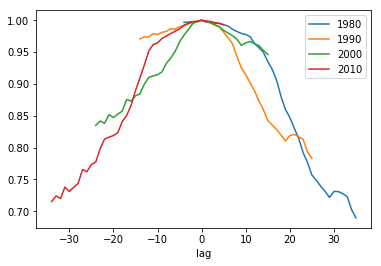

In [85]:
%matplotlib inline
# Plot
yr_sim.plot.line()

## 2. HHI

### 2.1 HHI for complete sample across locations, industries, primary classes

In [91]:
%matplotlib inline
sns.set(font_scale=1.4)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 20})
savepath = "DataStore/2018-07-P3/ResultsGraphs/"

In [88]:
yr_min = 1976
yr_max = 2015

hhi_all = pd.DataFrame()
for k in ["inv_msa", "naics_name", "primclass"]:
    yr_v = "gyear"
    pdf = pdf.loc[pdf[yr_v].isin(range(yr_min,yr_max+1))]
    ploc = pdf[[k, yr_v, "patent"]].groupby([k, yr_v]).count().reset_index()
    # Only use those places with greater than 10 patents
    ploc = ploc.loc[ploc["patent"] >= 10]
    ploc = ploc.pivot(index=yr_v, columns=k, values="patent").fillna(0)

    # Get proportions
    ploc = ploc.apply(lambda x: x/x.sum(), axis=1)

    hhi = pd.Series(np.sum(ploc.values**2,axis=1), index = list(range(yr_min,yr_max+1)))
    hhi_all[k] = hhi

In [ ]:
yr_min = 1976
yr_max = 2015
k = "naics_name"
yr_v = "gyear"
pdf = pdf.loc[pdf[yr_v].isin(range(yr_min,yr_max+1))]
ploc = pdf[[k, yr_v, "patent"]].groupby([k, yr_v]).count().reset_index()
# Only use those places with greater than 10 patents
ploc = ploc.loc[ploc["patent"] >= 10]
ploc = ploc.pivot(index=yr_v, columns="inv_msa", values="patent").fillna(0)

# Get proportions
ploc = ploc.apply(lambda x: x/x.sum(), axis=1)

hhi = pd.Series(np.sum(ploc.values**2,axis=1), index = list(range(yr_min,yr_max+1)))
hhi_naics_name = hhi

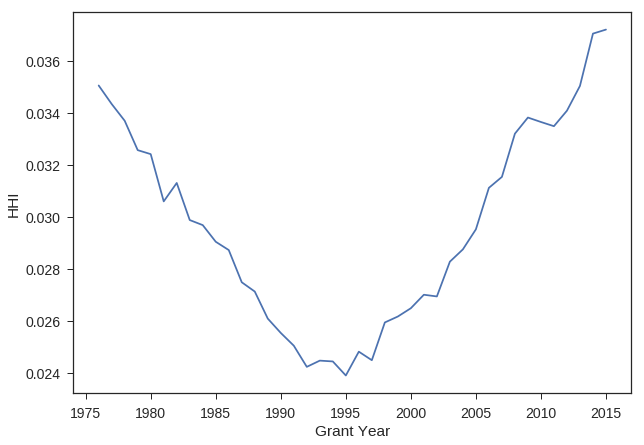

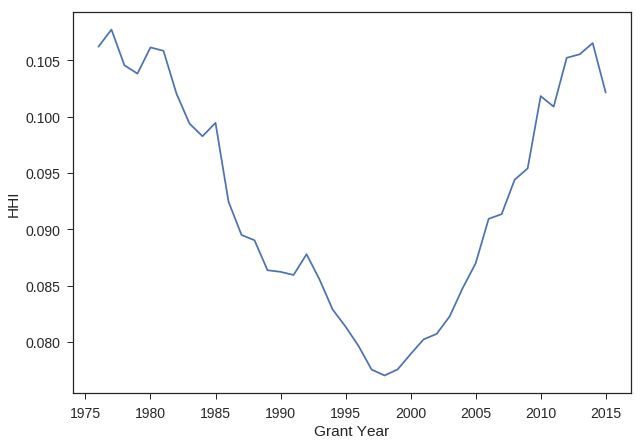

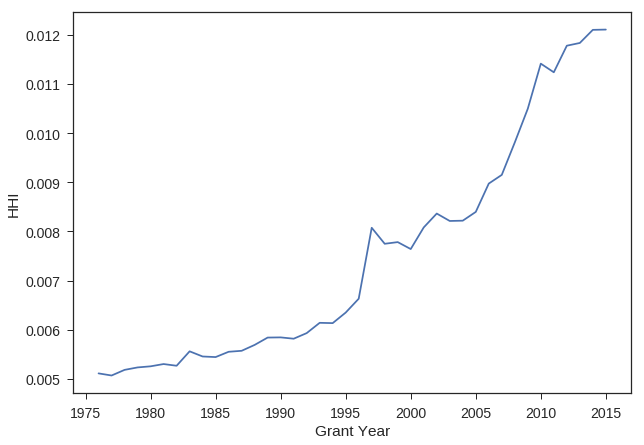

In [94]:
%matplotlib inline
# Plot
for k in hhi_all.columns:
    fig, ax = plt.subplots(figsize=(10,7))
    hhi_all[k].plot.line(ax=ax)
    ax.set_xlabel("Grant Year")
    ax.set_ylabel("HHI")
    plt.savefig(savepath+"1-HHI_{0}.png".format(k))
    plt.show()


### 2.2 HHI for top 5 industries over time across locations + HHI in general

In [187]:
k = "naics_name"
topn = 5
topnames = pdf[k].value_counts().sort_values(ascending=False)[:topn].index

yr_min = 1976
yr_max = 2015
k = "naics_name"
j = "inv_msa"
yr_v = "gyear"

hhi = pd.DataFrame()
for n in topnames:
    # Limit dataframe
    p2 = pdf.loc[pdf[yr_v].isin(range(yr_min,yr_max+1)) & (pdf[k] == n)]
    ploc = p2[[j, yr_v, "patent"]].groupby([j, yr_v]).count().reset_index()
    # Only use those places with greater than 10 patents
    ploc = ploc.loc[ploc["patent"] >= 10]
    ploc = ploc.pivot(index=yr_v, columns=j, values="patent").fillna(0)

    # Get proportions
    ploc = ploc.apply(lambda x: x/x.sum(), axis=1)

    hhi[n] = pd.Series(np.sum(ploc.values**2,axis=1), index = list(range(yr_min,yr_max+1)))
    
# Add all
h_all = hhi_all[["inv_msa"]].rename(columns={"inv_msa": "All"})

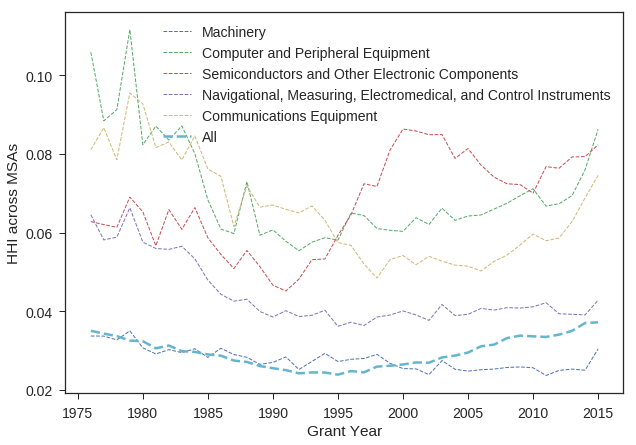

In [189]:
%matplotlib inline
# Plot

fig, ax = plt.subplots(figsize=(10,7))
hhi.plot.line(linestyle='dashed', alpha=1, linewidth=1, ax=ax)
h_all.plot.line(linestyle='dashed', alpha=1, linewidth=2.5, ax=ax)
ax.set_xlabel("Grant Year")
ax.set_ylabel("HHI across MSAs")
plt.legend(title="")

plt.savefig(savepath+"1-HHI_by_NAICS.png")
plt.show()


In [232]:
topncount = pdf[k].value_counts().sort_values(ascending=False)
topprop = topncount/topncount.sum()
topprop[:10]

Machinery                                                           0.158150
Computer and Peripheral Equipment                                   0.114277
Semiconductors and Other Electronic Components                      0.092647
Navigational, Measuring, Electromedical, and Control Instruments    0.090549
Communications Equipment                                            0.076908
Fabricated Metal Products                                           0.063848
Electrical Equipment, Appliances, and Components                    0.062127
Other Miscellaneous                                                 0.058670
Basic Chemicals                                                     0.052143
Other Chemical Product and Preparation                              0.051378
Name: naics_name, dtype: float64

### 2.3 HHI for Top Primclass over time across MSAs

In [131]:
# k = "primclass"
# topn = 5
# topnames = pdf[k].value_counts().sort_values(ascending=False)[:topn].index

# # Load primary class name
# pcn = pd.read_table("RawData/PatentView/mainclass_current.tsv")
# pcn = dict(zip(pcn["id"], pcn["title"]))

# yr_min = 1976
# yr_max = 2015
# j = "inv_msa"
# yr_v = "gyear"

# hhi = pd.DataFrame()
# for n in topnames:
#     # Limit dataframe
#     p2 = pdf.loc[pdf[yr_v].isin(range(yr_min,yr_max+1)) & (pdf[k] == n)]
#     ploc = p2[[j, yr_v, "patent"]].groupby([j, yr_v]).count().reset_index()
#     # Only use those places with greater than 10 patents
#     ploc = ploc.loc[ploc["patent"] >= 10]
#     ploc = ploc.pivot(index=yr_v, columns=j, values="patent").fillna(0)

#     # Get proportions
#     ploc = ploc.apply(lambda x: x/x.sum(), axis=1)
    
#     # Change name
#     n = pcn[str(int(n))]

#     hhi = pd.concat([hhi,pd.Series(np.sum(ploc.values**2,axis=1),\
#                                    index = list(range(p2[yr_v].min(), p2[yr_v].max()+1)))],
#                     axis=1)
#     hhi = hhi.rename(columns={0:n})
    
# # Add all
# hhi["All"] = hhi_all["inv_msa"]

## 3. Top Proportion in each $k$ for each year group
### 3.1 Inv MSA

In [237]:
k = "inv_msa"
yr_g = "year_group"

# Get counts
r2_t = pdf[[yr_g, k, "patent"]].groupby([yr_g, k]).count().reset_index()
# Pivot to matrix
r2_t = r2_t[[yr_g, k, "patent"]].pivot(\
        index=k, columns=yr_g, values = "patent")
# Get proportion
r2_t = r2_t.apply(lambda col: col/col.sum(), axis=0)
# Reset index
r2_t = r2_t.reset_index()

# Get rank by year group
n_rank = pd.DataFrame()
year_groups = pdf.loc[pdf[yr_g].notnull(), yr_g].unique()
for c in year_groups:
    n = r2_t[[c, k]].sort_values(c, ascending = False)
    n[c] = np.round(n[c],2)
    n = n[[k,c]]
    n = n.rename(columns={k: "{0} MSA".format(c), c: "Share"}).reset_index(drop=True)
    n_rank = pd.concat([n_rank,n], axis=1)

rank_high = n_rank[:10]

rank_high_msa = rank_high

In [238]:
display(rank_high_msa)
print(rank_high_msa.to_latex(index=False,escape=False,column_format="lclclclc"))

year_group,1975-85 MSA,Share,1985-95 MSA,Share,1995-05 MSA,Share,2005-15 MSA,Share
0,"New York-Northern New Jersey-Long Island, NY-N...",0.10,"New York-Northern New Jersey-Long Island, NY-N...",0.08,"San Jose-Sunnyvale-Santa Clara, CA",0.07,"San Jose-Sunnyvale-Santa Clara, CA",0.10
1,"Chicago-Joliet-Naperville, IL-IN-WI",0.06,"Los Angeles-Long Beach-Santa Ana, CA",0.05,"New York-Northern New Jersey-Long Island, NY-N...",0.06,"San Francisco-Oakland-Fremont, CA",0.07
2,"Los Angeles-Long Beach-Santa Ana, CA",0.06,"Chicago-Joliet-Naperville, IL-IN-WI",0.05,"Los Angeles-Long Beach-Santa Ana, CA",0.05,"New York-Northern New Jersey-Long Island, NY-N...",0.05
3,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",0.04,"Boston-Cambridge-Quincy, MA-NH",0.04,"San Francisco-Oakland-Fremont, CA",0.05,"Los Angeles-Long Beach-Santa Ana, CA",0.05
4,"Boston-Cambridge-Quincy, MA-NH",0.03,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",0.03,"Boston-Cambridge-Quincy, MA-NH",0.04,"Boston-Cambridge-Quincy, MA-NH",0.04
5,"Detroit-Warren-Livonia, MI",0.03,"San Jose-Sunnyvale-Santa Clara, CA",0.03,"Chicago-Joliet-Naperville, IL-IN-WI",0.04,"Seattle-Tacoma-Bellevue, WA",0.04
6,"San Francisco-Oakland-Fremont, CA",0.02,"San Francisco-Oakland-Fremont, CA",0.03,"Minneapolis-St. Paul-Bloomington, MN-WI",0.02,"San Diego-Carlsbad-San Marcos, CA",0.03
7,"San Jose-Sunnyvale-Santa Clara, CA",0.02,"Detroit-Warren-Livonia, MI",0.03,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",0.02,"Chicago-Joliet-Naperville, IL-IN-WI",0.03
8,"Houston-Sugar Land-Baytown, TX",0.02,"Houston-Sugar Land-Baytown, TX",0.02,"Detroit-Warren-Livonia, MI",0.02,"Minneapolis-St. Paul-Bloomington, MN-WI",0.02
9,"Pittsburgh, PA",0.02,"Minneapolis-St. Paul-Bloomington, MN-WI",0.02,"San Diego-Carlsbad-San Marcos, CA",0.02,"Austin-Round Rock-San Marcos, TX",0.02


\begin{tabular}{lclclclc}
\toprule
                                       1975-85 MSA &  Share &                                        1985-95 MSA &  Share &                                        1995-05 MSA &  Share &                                        2005-15 MSA &  Share \\
\midrule
 New York-Northern New Jersey-Long Island, NY-N... &   0.10 &  New York-Northern New Jersey-Long Island, NY-N... &   0.08 &                 San Jose-Sunnyvale-Santa Clara, CA &   0.07 &                 San Jose-Sunnyvale-Santa Clara, CA &   0.10 \\
               Chicago-Joliet-Naperville, IL-IN-WI &   0.06 &               Los Angeles-Long Beach-Santa Ana, CA &   0.05 &  New York-Northern New Jersey-Long Island, NY-N... &   0.06 &                  San Francisco-Oakland-Fremont, CA &   0.07 \\
              Los Angeles-Long Beach-Santa Ana, CA &   0.06 &                Chicago-Joliet-Naperville, IL-IN-WI &   0.05 &               Los Angeles-Long Beach-Santa Ana, CA &   0.05 &  New York-Northern New 

### 3.2 NAICS

In [235]:
k = "naics_name"
yr_g = "year_group"

# Get counts
r2_t = pdf[[yr_g, k, "patent"]].groupby([yr_g, k]).count().reset_index()
# Pivot to matrix
r2_t = r2_t[[yr_g, k, "patent"]].pivot(\
        index=k, columns=yr_g, values = "patent")
# Get proportion
r2_t = r2_t.apply(lambda col: col/col.sum(), axis=0)
# Reset index
r2_t = r2_t.reset_index()

# Get rank by year group
n_rank = pd.DataFrame()
year_groups = pdf.loc[pdf[yr_g].notnull(), yr_g].unique()
for c in year_groups:
    n = r2_t[[c, k]].sort_values(c, ascending = False)
    n[c] = np.round(n[c],2)
    n = n[[k,c]]
    n = n.rename(columns={k: "{0} NAICS".format(c), c: "Share"}).reset_index(drop=True)
    n_rank = pd.concat([n_rank,n], axis=1)

rank_high = n_rank[:10]

rank_high_naics = rank_high

In [236]:
display(rank_high_naics)
print(rank_high_naics.to_latex(index=False,escape=False,column_format="lclclclc"))

year_group,1975-85 NAICS,Share,1985-95 NAICS,Share,1995-05 NAICS,Share,2005-15 NAICS,Share
0,Machinery,0.24,Machinery,0.20,Machinery,0.16,Computer and Peripheral Equipment,0.19
1,Fabricated Metal Products,0.10,Fabricated Metal Products,0.10,Semiconductors and Other Electronic Components,0.10,Machinery,0.12
2,Basic Chemicals,0.09,"Navigational, Measuring, Electromedical, and C...",0.08,"Navigational, Measuring, Electromedical, and C...",0.09,Communications Equipment,0.11
3,"Electrical Equipment, Appliances, and Components",0.07,Semiconductors and Other Electronic Components,0.07,Computer and Peripheral Equipment,0.09,Semiconductors and Other Electronic Components,0.10
4,Other Miscellaneous,0.07,"Electrical Equipment, Appliances, and Components",0.07,"Electrical Equipment, Appliances, and Components",0.06,"Navigational, Measuring, Electromedical, and C...",0.10
5,"Navigational, Measuring, Electromedical, and C...",0.07,Basic Chemicals,0.07,Communications Equipment,0.06,"Electrical Equipment, Appliances, and Components",0.05
6,Other Chemical Product and Preparation,0.06,Other Miscellaneous,0.07,Fabricated Metal Products,0.06,Other Miscellaneous,0.05
7,Semiconductors and Other Electronic Components,0.06,Other Chemical Product and Preparation,0.06,Other Miscellaneous,0.06,Other Chemical Product and Preparation,0.04
8,Plastics and Rubber Products,0.05,Plastics and Rubber Products,0.05,Other Chemical Product and Preparation,0.06,Fabricated Metal Products,0.04
9,Communications Equipment,0.03,Communications Equipment,0.04,Basic Chemicals,0.05,Pharmaceutical and Medicines,0.04


\begin{tabular}{lclclclc}
\toprule
                                     1975-85 NAICS &  Share &                                      1985-95 NAICS &  Share &                                      1995-05 NAICS &  Share &                                      2005-15 NAICS &  Share \\
\midrule
                                         Machinery &   0.24 &                                          Machinery &   0.20 &                                          Machinery &   0.16 &                  Computer and Peripheral Equipment &   0.19 \\
                         Fabricated Metal Products &   0.10 &                          Fabricated Metal Products &   0.10 &     Semiconductors and Other Electronic Components &   0.10 &                                          Machinery &   0.12 \\
                                   Basic Chemicals &   0.09 &  Navigational, Measuring, Electromedical, and C... &   0.08 &  Navigational, Measuring, Electromedical, and C... &   0.09 &                        

### 3.3 Primary class

In [68]:
# Load primary class name
pcn = pd.read_table("RawData/PatentView/mainclass_current.tsv")
pcn = dict(zip(pcn["id"], pcn["title"]))

In [74]:
k = "primclass"
yr_g = "year_group"

# Get counts
r2_t = pdf[[yr_g, k, "patent"]].groupby([yr_g, k]).count().reset_index()
# Pivot to matrix
r2_t = r2_t[[yr_g, k, "patent"]].pivot(\
        index=k, columns=yr_g, values = "patent")
# Get proportion
r2_t = r2_t.apply(lambda col: col/col.sum(), axis=0)
# Reset index
r2_t = r2_t.reset_index()

# Get rank by year group
n_rank = pd.DataFrame()
year_groups = pdf.loc[pdf[yr_g].notnull(), yr_g].unique()
for c in year_groups:
    n = r2_t[[c, k]].sort_values(c, ascending = False)[:100]
    n[c] = np.round(n[c],3)
    # Change number of primclass to name
    n[k] = n[k].apply(lambda x: str(int(x))+": {0}".format(pcn[str(str(int(x)))][:20]))
    n = n[[k,c]]
    n = n.rename(columns={k: "{0} NAICS".format(c), c: "Share"}).reset_index(drop=True)
    n_rank = pd.concat([n_rank,n], axis=1)

rank_high = n_rank[:10]

rank_high_pc = rank_high

In [234]:
display(rank_high_pc)
print(rank_high_pc.to_latex(index=False,escape=False,column_format="lclclclc"))

year_group,1975-85 NAICS,Share,1985-95 NAICS,Share,1995-05 NAICS,Share,2005-15 NAICS,Share
0,"514: DRUG, BIO-AFFECTING",0.019,"514: DRUG, BIO-AFFECTING",0.022,435: CHEMISTRY: MOLECULAR,0.029,370: MULTIPLEX COMMUNICAT,0.034
1,73: MEASURING AND TESTIN,0.016,428: STOCK MATERIAL OR MI,0.018,"514: DRUG, BIO-AFFECTING",0.028,709: ELECTRICAL COMPUTERS,0.027
2,428: STOCK MATERIAL OR MI,0.015,73: MEASURING AND TESTIN,0.014,"424: DRUG, BIO-AFFECTING",0.021,"514: DRUG, BIO-AFFECTING",0.025
3,524: SYNTHETIC RESINS OR,0.012,604: SURGERY,0.013,438: SEMICONDUCTOR DEVICE,0.021,705: DATA PROCESSING: FIN,0.025
4,29: METAL WORKING,0.011,"424: DRUG, BIO-AFFECTING",0.013,428: STOCK MATERIAL OR MI,0.017,455: TELECOMMUNICATIONS,0.024
5,210: LIQUID PURIFICATION,0.010,435: CHEMISTRY: MOLECULAR,0.013,257: ACTIVE SOLID-STATE D,0.015,438: SEMICONDUCTOR DEVICE,0.021
6,137: FLUID HANDLING,0.010,210: LIQUID PURIFICATION,0.012,600: SURGERY,0.014,435: CHEMISTRY: MOLECULAR,0.020
7,156: ADHESIVE BONDING AND,0.010,29: METAL WORKING,0.011,606: SURGERY,0.013,257: ACTIVE SOLID-STATE D,0.019
8,423: CHEMISTRY OF INORGAN,0.010,439: ELECTRICAL CONNECTOR,0.011,370: MULTIPLEX COMMUNICAT,0.013,707: DATA PROCESSING: DA,0.018
9,52: STATIC STRUCTURES (E,0.009,250: RADIANT ENERGY,0.011,604: SURGERY,0.012,"424: DRUG, BIO-AFFECTING",0.018


\begin{tabular}{lclclclc}
\toprule
             1975-85 NAICS &  Share &              1985-95 NAICS &  Share &              1995-05 NAICS &  Share &              2005-15 NAICS &  Share \\
\midrule
 514: DRUG, BIO-AFFECTING  &  0.019 &  514: DRUG, BIO-AFFECTING  &  0.022 &  435: CHEMISTRY: MOLECULAR &  0.029 &  370: MULTIPLEX COMMUNICAT &  0.034 \\
  73: MEASURING AND TESTIN &  0.016 &  428: STOCK MATERIAL OR MI &  0.018 &  514: DRUG, BIO-AFFECTING  &  0.028 &  709: ELECTRICAL COMPUTERS &  0.027 \\
 428: STOCK MATERIAL OR MI &  0.015 &   73: MEASURING AND TESTIN &  0.014 &  424: DRUG, BIO-AFFECTING  &  0.021 &  514: DRUG, BIO-AFFECTING  &  0.025 \\
 524: SYNTHETIC RESINS OR  &  0.012 &               604: SURGERY &  0.013 &  438: SEMICONDUCTOR DEVICE &  0.021 &  705: DATA PROCESSING: FIN &  0.025 \\
         29: METAL WORKING &  0.011 &  424: DRUG, BIO-AFFECTING  &  0.013 &  428: STOCK MATERIAL OR MI &  0.017 &    455: TELECOMMUNICATIONS &  0.024 \\
 210: LIQUID PURIFICATION  &  0.010 & 

## 4. Average similarity across industries over time

In [157]:
nsim = fastparquet.ParquetFile("DataStore/2018-07-P2/Reg0726/reg_naics_name_sim_tr_0726.parq")\
.to_pandas(["tp", "tp_naics_name", "tp_primclass", "tp_gyear", "sim_ldavecs", "sim_docvecs",\
            "year_group", "inv_msa_match"])


In [183]:
k = "naics_name"
dm = "sim_docvecs"
yr_v = "tp_gyear"
k1 = "tp_{0}".format(k)

topn = 5
topnames = pdf[k].value_counts().sort_values(ascending=False)[:topn].index

av_sim = nsim.loc[nsim[k1].isin(topnames), [k1, dm, yr_v]].groupby([k1,yr_v]).mean().reset_index()
av_sim = av_sim.pivot(index=yr_v, columns=k1, values=dm).fillna(0)
av_sim_all = nsim[[dm, yr_v]].groupby(yr_v).mean().rename(columns={"sim_docvecs": "All"})

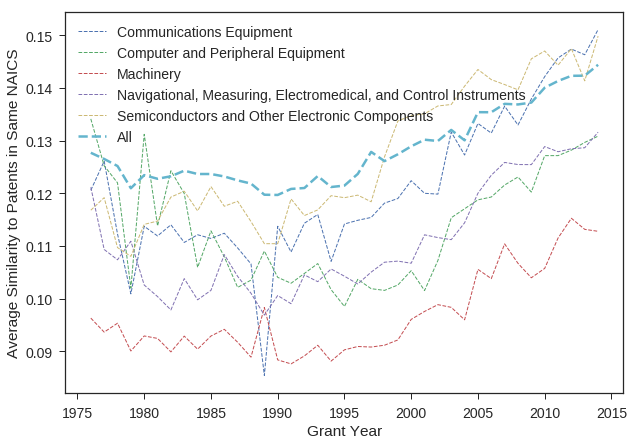

In [185]:
%matplotlib inline
# Plot

fig, ax = plt.subplots(figsize=(10,7))
av_sim.plot.line(linestyle='dashed', alpha=1, linewidth=1, ax=ax)
av_sim_all.plot.line(linestyle='dashed', alpha=1, linewidth=2.5, ax=ax)
ax.set_xlabel("Grant Year")
ax.set_ylabel("Average Similarity to Patents in Same NAICS")
plt.legend(title="")
plt.savefig(savepath+"1-Sim_by_NAICS.png")
plt.show()


## 5. Size of localization by industry

In [173]:
def get_year_group(x):
    if x in range(1975,1980):
        yg = "1975-80"
    elif x in range(1980,1985):
        yg = "1980-85"
    elif x in range(1985, 1990):
        yg = "1985-90"
    elif x in range(1990,1995):
        yg = "1990-95"
    elif x in range(1995,2000):
        yg = "1995-00"
    elif x in range(2000,2005):
        yg = "2000-05"
    elif x in range(2005,2010):
        yg = "2005-10"
    elif x in range(2010, 2015):
        yg = "2010-15"
    else:
        yg = np.nan
    return yg
nsim["year_group_5"] = nsim["tp_gyear"].apply(get_year_group)

In [196]:
k = "naics_name"
dm = "sim_docvecs"
yr_v = "year_group_5"
# yr_v = "tp_gyear"
k1 = "tp_{0}".format(k)

topn = 5
topnames = pdf[k].value_counts().sort_values(ascending=False)[:topn].index

# Get difference of mean local sim vs non local sim
r2 = nsim
r2_t = r2.loc[r2["inv_msa_match"] == True, [yr_v, k1, dm]].groupby([yr_v, k1]).mean()
r2_f = r2.loc[r2["inv_msa_match"] == False, [yr_v, k1, dm]].groupby([yr_v, k1]).mean()
r2_t["sim_F"] = r2_f["sim_docvecs"]
r2_t["Diff"] = r2_t["sim_docvecs"]-r2_t["sim_F"]
r2_t = r2_t.reset_index()[[yr_v, k1, "Diff"]].pivot(index="tp_naics_name", columns=yr_v, values = "Diff").reset_index()

# Number of pairs in each
r2_p = r2[[yr_v, k1, dm]].groupby([yr_v,k1]).count().reset_index()
r2_p = r2_p.pivot(index=k1, columns=yr_v, values = dm)

In [199]:
r2_t2 = r2_t.loc[r2_t[k1].isin(topnames)]
r2_t2 = r2_t2.set_index(k1).T

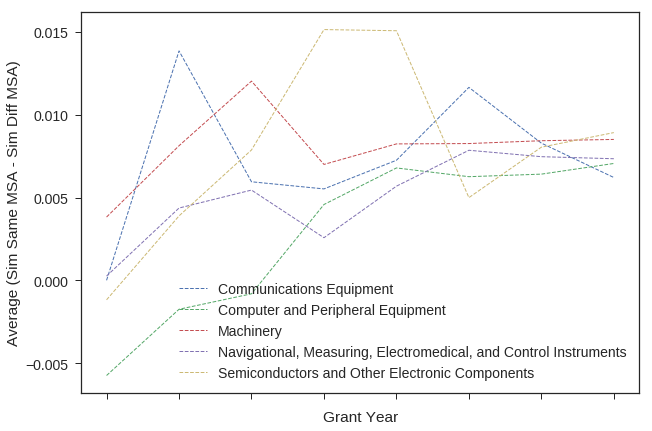

In [200]:
%matplotlib inline
# Plot

fig, ax = plt.subplots(figsize=(10,7))
r2_t2.plot.line(linestyle='dashed', alpha=1, linewidth=1, ax=ax)
ax.set_xlabel("Grant Year")
ax.set_ylabel("Average (Sim Same MSA - Sim Diff MSA)")
plt.legend(title="")
plt.savefig(savepath+"1-Loc_by_NAICS.png")
plt.show()

### Rankings by localization per year

In [228]:
k = "naics_name"
dm = "sim_docvecs"
yr_v = "year_group"
# yr_v = "tp_gyear"
k1 = "tp_{0}".format(k)

# Get difference of mean local sim vs non local sim
r2 = nsim
r2_t = r2.loc[r2["inv_msa_match"] == True, [yr_v, k1, dm]].groupby([yr_v, k1]).mean()
r2_f = r2.loc[r2["inv_msa_match"] == False, [yr_v, k1, dm]].groupby([yr_v, k1]).mean()
r2_t["sim_F"] = r2_f["sim_docvecs"]
r2_t["Diff"] = r2_t["sim_docvecs"]-r2_t["sim_F"]
# r2_t["Diff"] = r2_t["sim_docvecs"]/r2_t["sim_F"]
r2_t = r2_t.reset_index()[[yr_v, k1, "Diff"]].pivot(index="tp_naics_name", columns=yr_v, values = "Diff").reset_index()

# Number of pairs in each
r2_p = r2[[yr_v, k1, dm]].groupby([yr_v,k1]).count().reset_index()
r2_p = r2_p.pivot(index=k1, columns=yr_v, values = dm)

In [229]:
n_rank = pd.DataFrame()
year_groups = sorted(r2["year_group"].unique())
topn = 10
for c in year_groups:
    n = r2_t[[c, "tp_naics_name"]].sort_values(c, ascending = False).reset_index(drop=True)
    # Only use industries with greater than 1000 pairs in sample that year
    n = n.loc[n["tp_naics_name"].isin(r2_p.loc[(r2_p[c] >= 1000)].index)].reset_index(drop=True)
    n[c] = np.round(n[c],3)
    n = n.rename(columns={"tp_naics_name": "{0} NAICS".format(c)})
    n_rank = pd.concat([n_rank,n], axis=1)

n_rank_high = n_rank[:topn]

In [230]:
n_rank_high

year_group,1975-85,1975-85 NAICS,1985-95,1985-95 NAICS,1995-05,1995-05 NAICS,2005-15,2005-15 NAICS
0,0.025,Nonmetallic Mineral Products,0.036,Other Transportation Equipment,0.028,Nonmetallic Mineral Products,0.023,"Resin, Synthetic Rubber, and Artificial and Sy..."
1,0.019,Other Transportation Equipment,0.024,"Textiles, Apparel and Leather",0.023,Other Computer and Electronic Products,0.022,Other Transportation Equipment
2,0.018,"Textiles, Apparel and Leather",0.022,Aerospace Product and Parts,0.021,Other Transportation Equipment,0.020,Nonmetallic Mineral Products
3,0.015,Medical Equipment and Supplies,0.020,Nonmetallic Mineral Products,0.016,"Motor Vehicles, Trailers and Parts",0.017,"Textiles, Apparel and Leather"
4,0.010,"Motor Vehicles, Trailers and Parts",0.020,Other Computer and Electronic Products,0.016,Medical Equipment and Supplies,0.014,Food
5,0.009,Plastics and Rubber Products,0.013,Primary Metal,0.015,Aerospace Product and Parts,0.014,Other Miscellaneous
6,0.008,Other Computer and Electronic Products,0.012,Other Miscellaneous,0.011,Other Miscellaneous,0.013,Other Computer and Electronic Products
7,0.008,Communications Equipment,0.012,Semiconductors and Other Electronic Components,0.011,Furniture and Related Products,0.012,Basic Chemicals
8,0.007,Other Miscellaneous,0.010,"Motor Vehicles, Trailers and Parts",0.011,"Textiles, Apparel and Leather",0.012,Medical Equipment and Supplies
9,0.006,Machinery,0.009,Machinery,0.010,Communications Equipment,0.010,"Motor Vehicles, Trailers and Parts"
